The goal is to create a chatbot to help in the recruitment process
organization - Pirates

In [ ]:
# Importing Libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM , Dense,GlobalMaxPooling1D,Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [ ]:
%%writefile content.json
{"intents":
  [
    {
      "tag":"greeting",
      "input":["hello","hey","Hi there,nice to meet you"]
      "responses":[
        "Hi , Welcome to the worlds largest organization",
        "Hey, Do you need help?",
        "Welcome aboard "
      ]
    },
    {
      "tag":"goodbye",
      "input":["Thank You","bye","Thanks for the info","Thanks"]
      "responses":[
        "Okay , bye",
        "Goodbye"
      ]
    }
  ]}

Writing content.json


In [ ]:
%%writefile content.json
{
  "intents": [
    {
      "tag": "greeting",
      "input": ["hello", "hey", "hi there", "nice to meet you"],
      "responses": [
        "Hi, Welcome to the world's largest organization!",
        "Hey, Do you need help?",
        "Welcome aboard!"
      ]
    },
    {
      "tag": "goodbye",
      "input": ["thank you", "bye", "thanks for the info", "thanks"],
      "responses": ["Okay, bye", "Goodbye"]
    },
    {
      "tag": "recruitment_info",
      "input": ["Tell me about job opportunities", "What positions are open?", "Job vacancies"],
      "responses": [
        "We have various job opportunities across different departments.",
        "Sure, we have open positions in areas such as Sales, Marketing, Engineering, and more.",
        "Interested in joining our team? We have job vacancies in multiple fields."
      ]
    },
    {
      "tag": "application_process",
      "input": ["How can I apply?", "What's the application process?", "Applying for a job"],
      "responses": [
        "To apply for a position, please visit our careers page on our website.",
        "You can submit your application through our website's careers section.",
        "Applying is easy! Just head to our website and navigate to the careers page to submit your application."
      ]
    },
    {
      "tag": "interview_process",
      "input": ["Tell me about the interview process", "What's the interview like?", "Interview stages"],
      "responses": [
        "Our interview process usually involves initial screening, technical interview, and final HR interview.",
        "The interview process includes multiple stages, such as technical assessments and interviews with team members.",
        "Expect a comprehensive interview process including technical evaluations and discussions with our team."
      ]
    },
    {
      "tag": "salary_info",
      "input": ["What's the salary range?", "How much do you pay?", "Salary details"],
      "responses": [
        "Our salary packages are competitive and vary depending on the role and experience.",
        "We offer competitive salaries that are tailored to the specific role and the candidate's qualifications.",
        "Salary ranges are determined based on factors such as the role's complexity and the candidate's expertise."
      ]
    },
    {
      "tag": "work_environment",
      "input": ["Tell me about the work environment", "What's it like to work here?", "Office culture"],
      "responses": [
        "Our work environment is collaborative, innovative, and focused on personal and professional growth.",
        "We foster a dynamic work environment that encourages creativity, teamwork, and continuous learning.",
        "You'll find a positive and inclusive work culture that values diversity and promotes a healthy work-life balance."
      ]
    },
    {
      "tag": "how_to_get_recruited",
      "input": ["How can I get recruited?", "What's the recruitment process?", "Steps to join"],
      "responses": [
        "To get recruited, start by exploring our open positions on our website's careers page.",
        "The recruitment process begins with browsing our available job opportunities and submitting your application online.",
        "You can initiate the recruitment process by checking out our job listings and following the application instructions provided."
      ]
    },
    {
      "tag": "joining_process",
      "input": ["What's the joining process?", "Steps to join after selection", "After getting hired"],
      "responses": [
        "After your selection, you'll go through an onboarding process that includes orientation, paperwork, and team introductions.",
        "Once you're selected, we'll guide you through our onboarding process which covers paperwork, orientation, and team introductions.",
        "Upon being hired, our onboarding process will assist you in smoothly transitioning into your new role with orientation and introductions to your team."
      ]
    },
    {
      "tag": "location_info",
      "input": ["Where are you located?", "What's your office address?", "Location details"],
      "responses": [
        "Our main office is located in the heart of the city at [Office Address].",
        "You can find us in the city center at [Office Address].",
        "Our office is conveniently situated at [Office Address] in the city."
      ]
    },
    {
      "tag": "prerequisite_info",
      "input": ["What are the prerequisites?", "Requirements to apply?", "Qualifications needed"],
      "responses": [
        "Prerequisites vary based on the role, but generally, we look for relevant experience and qualifications.",
        "We have specific prerequisites for each role, usually including relevant qualifications and experience.",
        "The prerequisites depend on the role, but typically include qualifications and experience in the related field."
      ]
    }

  ]
}


Overwriting content.json


In [ ]:
#Importing dataset
with open('content.json') as content:
  data1=json.load(content)

In [ ]:
#Getting all the data to lists
tags=[]
inputs=[]
responses={}
for intent in data1["intents"]:
  responses[intent['tag']]=intent['responses']
  for lines in intent['input']:
    inputs.append(lines)
    tags.append(intent['tag'])

In [ ]:
#Converting to dataframe
data=pd.DataFrame({"inputs":inputs,
                   "tags":tags})

In [ ]:
data

,inputs,tags
0,hello,greeting
1,hey,greeting
2,hi there,greeting
3,nice to meet you,greeting
4,thank you,goodbye
5,bye,goodbye
6,thanks for the info,goodbye
7,thanks,goodbye
8,Tell me about job opportunities,recruitment_info
9,What positions are open?,recruitment_info


Preprocessing



In [ ]:
#Removing Punctuations
import string
data['inputs']=data['inputs'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['inputs']=data['inputs'].apply(lambda wrd:''.join(wrd))
data

,inputs,tags
0,hello,greeting
1,hey,greeting
2,hi there,greeting
3,nice to meet you,greeting
4,thank you,goodbye
5,bye,goodbye
6,thanks for the info,goodbye
7,thanks,goodbye
8,tell me about job opportunities,recruitment_info
9,what positions are open,recruitment_info


We are training a neural network or deep learning model from this dataset

In [ ]:
#Tokenize the data
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer=Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['inputs'])
train=tokenizer.texts_to_sequences(data['inputs'])

#Apply padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_train=pad_sequences(train)

#Encoding the outputs
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
y_train=le.fit_transform(data['tags'])

In [ ]:
!pip install tensorflow

Tokenizer assigns a unique token to each distinct word and padding is done to get all the data to the same length so as to send it to an mn layer


In [ ]:
input_shape=X_train.shape[1]
print(input_shape)

6


In [ ]:
#Define vocabulary
vocabulary=len(tokenizer.word_index)
print("Number of unique words:",vocabulary)
#output_length= le.classes_shape[0]
#print("Output length:",output_length)

Number of unique words: 67


In [ ]:
output_length = le.classes_.shape[0]
print("Output length:", output_length)


Output length: 11


NEURAL NETWORK
The network consists of an embedding layer which is one of the most powerful things in the field of natural language processing. The outputs of the embedding layer is the input of the recurrent layer with lstm gate. Then , the output is flattened and a regular dense layer is used with a softmax activation function


In [ ]:
#Creating a model

i=Input(shape=(input_shape))
x=Embedding(vocabulary+1,10)(i)
x=LSTM(10,return_sequences=True)(x)
x=Flatten()(x)
x=Dense(output_length,activation="softmax")(x)
model=Model(i,x)

In [ ]:
#Compiling the model
model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])


Why are we using LSTM ?


In [ ]:
#Trainig the model
train=model.fit(X_train,y_train,epochs=200)


Epoch 1/200
2/2 [==============================] - 3s 23ms/step - loss: 2.3955 - accuracy: 0.0857
Epoch 2/200
2/2 [==============================] - 0s 12ms/step - loss: 2.3939 - accuracy: 0.1429
Epoch 3/200
2/2 [==============================] - 0s 13ms/step - loss: 2.3925 - accuracy: 0.1143
Epoch 4/200
2/2 [==============================] - 0s 13ms/step - loss: 2.3913 - accuracy: 0.1143
Epoch 5/200
2/2 [==============================] - 0s 11ms/step - loss: 2.3900 - accuracy: 0.1714
Epoch 6/200
2/2 [==============================] - 0s 12ms/step - loss: 2.3890 - accuracy: 0.1714
Epoch 7/200
2/2 [==============================] - 0s 15ms/step - loss: 2.3879 - accuracy: 0.1714
Epoch 8/200
2/2 [==============================] - 0s 15ms/step - loss: 2.3867 - accuracy: 0.2000
Epoch 9/200
2/2 [==============================] - 0s 13ms/step - loss: 2.3857 - accuracy: 0.2571
Epoch 10/200
2/2 [==============================] - 0s 13ms/step - loss: 2.3845 - accuracy: 0.2571
Epoch 11/200
2/2 [=

For the chatbot , the model is supposed to identify the tag the input belongs to


MODEL ANALYSIS


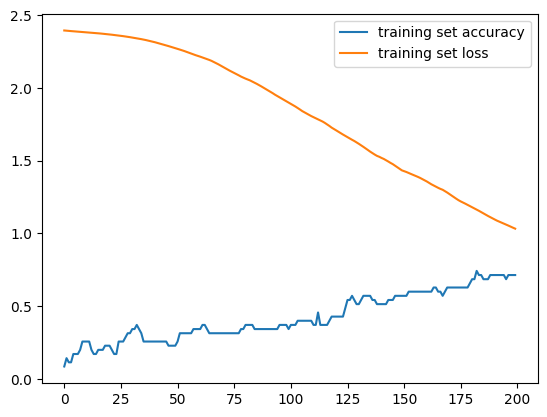

In [ ]:
#Plotting model accuracy

plt.plot(train.history['accuracy'],label='training set accuracy')
plt.plot(train.history['loss'],label='training set loss')
plt.legend()

TESTING

In [ ]:
#Chatting

import random

while True:
  texts_p=[]
  prediction_input=input('You:')

  #Removing punctuation and converting to lowercase
  prediction_input=[letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input=''.join(prediction_input)
  texts_p.append(prediction_input)

  #Tokenizing and Padding
  prediction_input=tokenizer.texts_to_sequences(texts_p)
  prediction_input=np.array(prediction_input).reshape(-1)
  prediction_input=pad_sequences([prediction_input],input_shape)

  #Getting output from model
  output=model.predict(prediction_input)
  output=output.argmax()

  #Finding the right tag and predicting
  response_tag=le.inverse_transform([output])[0]
  print("SRIBOT:",random.choice(responses[response_tag]))
  if response_tag=="goodbye":
    break

In [ ]:
import gradio as gr

def chat_with_bot(text):
    texts_p = []
    prediction_input = text.lower()  # Convert to lowercase
    texts_p.append(prediction_input)

    # Tokenizing and Padding
    prediction_input = tokenizer.texts_to_sequences(texts_p)
    prediction_input = np.array(prediction_input).reshape(-1)
    prediction_input = pad_sequences([prediction_input], input_shape)

    # Getting output from model
    output = model.predict(prediction_input)
    output = output.argmax()

    # Finding the right tag and predicting
    response_tag = le.inverse_transform([output])[0]
    response = random.choice(responses[response_tag])

    # Remove the "SRIBOT:" prefix from the response
    response = response.replace("SRIBOT:", "").strip()

    return response, response_tag == "goodbye"

input_text = gr.inputs.Textbox(lines=2, label="You")
output_text = gr.outputs.Textbox(label="SRIBOT")

iface = gr.Interface(fn=chat_with_bot, inputs=input_text, outputs=output_text, live=True, capture_session=True)
iface.launch()

In [ ]:
!pip install gradio

Conclusion :

This is the chatbot that i have created with tensorflow2 utilizing the power of embedding matrix

